## Libraries

In [1]:
!pip install numpy pandas librosa matplotlib seaborn scikit-learn keras resampy keras-focal-loss


ERROR: Could not find a version that satisfies the requirement keras-focal-loss (from versions: none)
ERROR: No matching distribution found for keras-focal-loss


In [4]:
import tensorflow.keras.backend as K
import tensorflow as tf

def categorical_focal_loss(gamma=2., alpha=.25):
    def focal_loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss


In [7]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, BatchNormalization, Dropout,
                                     Flatten, Dense, LSTM, Bidirectional, GlobalAveragePooling1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from keras_focal_loss import categorical_focal_loss?

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import

In [9]:
speech_path = '/content/drive/MyDrive/mars/Audio_Speech_Actors_01-24'
song_path = '/content/drive/MyDrive/mars/Audio_Song_Actors_01-24'


In [6]:
# # Cell 2
# # Define Dataset Paths

# speech_path = 'path_to/Audio_Speech_Actors_01-24'
# song_path = 'path_to/Audio_Song_Actors_01-24'


## Emotion Mapping

In [10]:
# Cell 3
# Define Emotion Mapping according to RAVDESS filename convention

emotion_dict = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}


## Extract Features

In [8]:
# def extract_features(file_path, augment=False):
#     y, sr = librosa.load(file_path, duration=3, offset=0.5, sr=22050)  # ← Fixed sr

#     if augment:
#         n_steps = np.random.randint(-2, 3)
#         y = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
#         noise_amp = 0.005 * np.random.uniform() * np.amax(y)
#         y += noise_amp * np.random.normal(size=y.shape)
#         pad_len = np.random.randint(0, 2000)
#         y = np.pad(y, (pad_len, 0), mode='constant')[:sr*3]

#     mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=60, hop_length=512)  # shape: (60, time_steps)

#     # CRITICAL: Ensure consistent time dimension BEFORE transpose
#     target_length = 130  # ~3 seconds at sr=22050, hop_length=512
#     if mfcc.shape[1] < target_length:  # ✓ shape[1] is time_steps before transpose
#         # Pad with zeros
#         pad_width = target_length - mfcc.shape[1]
#         mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
#     else:
#         # Truncate
#         mfcc = mfcc[:, :target_length]

#     # Now transpose to (time_steps, features)
#     mfcc = mfcc.T  # shape: (130, 60)
#     return mfcc

In [11]:
def extract_features(file_path, augment=False, label=None):
    y, sr = librosa.load(file_path, duration=3, offset=0.5, sr=22050)

    if augment and label in ['sad', 'happy']:
        n_steps = np.random.randint(-3, 4)
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
        noise_amp = 0.005 * np.random.uniform() * np.amax(y)
        y += noise_amp * np.random.normal(size=y.shape)
        pad_len = np.random.randint(0, 2000)
        y = np.pad(y, (pad_len, 0), mode='constant')[:sr*3]
        # Extra Augment
        if np.random.rand() < 0.5:
            y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.8, 1.2))

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=60, hop_length=512)
    target_length = 130
    if mfcc.shape[1] < target_length:
        pad_width = target_length - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :target_length]
    return mfcc.T


In [12]:
features = []

print("Starting Feature Extraction Process...\n")

print("Processing Speech Files...")
for folder in os.listdir(speech_path):
    print(f"Processing Speech Actor Folder: {folder}")
    for file in os.listdir(os.path.join(speech_path, folder)):
        file_path = os.path.join(speech_path, folder, file)
        emotion_label = emotion_dict[file.split('-')[2]]

        features.append([extract_features(file_path, augment=False), emotion_label])
        features.append([extract_features(file_path, augment=True), emotion_label])

print("\nFinished processing Speech Files.\n")

print("Processing Song Files...")
for folder in os.listdir(song_path):
    print(f"Processing Song Actor Folder: {folder}")
    for file in os.listdir(os.path.join(song_path, folder)):
        file_path = os.path.join(song_path, folder, file)
        emotion_label = emotion_dict[file.split('-')[2]]

        features.append([extract_features(file_path, augment=False), emotion_label])
        features.append([extract_features(file_path, augment=True), emotion_label])

print("\nFinished processing Song Files.\n")

print("Creating DataFrame from extracted features...")
df = pd.DataFrame(features, columns=['feature', 'emotion'])
print("DataFrame created successfully!")
print(f"Total samples: {len(df)}\n")

Starting Feature Extraction Process...

Processing Speech Files...
Processing Speech Actor Folder: Actor_05
Processing Speech Actor Folder: Actor_03
Processing Speech Actor Folder: Actor_09
Processing Speech Actor Folder: Actor_06
Processing Speech Actor Folder: Actor_08
Processing Speech Actor Folder: Actor_04
Processing Speech Actor Folder: Actor_02
Processing Speech Actor Folder: Actor_01
Processing Speech Actor Folder: Actor_07
Processing Speech Actor Folder: Actor_11
Processing Speech Actor Folder: Actor_16
Processing Speech Actor Folder: Actor_17
Processing Speech Actor Folder: Actor_12
Processing Speech Actor Folder: Actor_18
Processing Speech Actor Folder: Actor_14
Processing Speech Actor Folder: Actor_15
Processing Speech Actor Folder: Actor_13
Processing Speech Actor Folder: Actor_10
Processing Speech Actor Folder: Actor_19
Processing Speech Actor Folder: Actor_20
Processing Speech Actor Folder: Actor_24
Processing Speech Actor Folder: Actor_22
Processing Speech Actor Folder:

## Encoding and splitting

In [13]:
X = np.array([i for i in df['feature']])
y = np.array(df['emotion'].tolist())

# Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)
print("Classes:", label_encoder.classes_)

Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


## feature scalling

In [14]:
num_samples, time_steps, n_mfcc = X.shape
X_flat = X.reshape(num_samples * time_steps, n_mfcc)
scaler = StandardScaler()
X_scaled_flat = scaler.fit_transform(X_flat)
## CHANGE
X_scaled = X_scaled_flat.reshape(num_samples, time_steps, n_mfcc)

## Split

In [15]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

## Imbalance

In [16]:
y_train_encoded = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weight_dict = dict(enumerate(class_weights))

## Model

In [17]:
# Model
num_classes = y_cat.shape[1]
model = Sequential([
    Conv1D(128, 5, padding='same', activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(), MaxPooling1D(2), Dropout(0.3),

    Conv1D(64, 5, padding='same', activation='relu'),
    BatchNormalization(), MaxPooling1D(2), Dropout(0.3),

    Conv1D(32, 3, padding='same', activation='relu'),
    BatchNormalization(), #MaxPooling1D(2), Dropout(0.3),

    # GlobalAveragePooling1D(),

    Bidirectional(LSTM(128, return_sequences=True)), Dropout(0.3),
    Bidirectional(LSTM(64)), Dropout(0.3),

    Dense(128, activation='relu'), Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

# model.compile(optimizer=Adam(5e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.compile(optimizer=Adam(5e-4),
              loss=categorical_focal_loss(gamma=2),  # Correct multi-class focal loss
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 130, 128)       │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 130, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 65, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 65, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 65, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 65, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 32, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32, 256)        │       164,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,384 (1.65 MB)

 Trainable params: 432,936 (1.65 MB)

 Non-trainable params: 448 (1.75 KB)

## Training

In [18]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

In [19]:
# history = model.fit(
#     X_train, y_train,
#     epochs=100,
#     batch_size=32,
#     validation_data=(X_test, y_test),
#     callbacks=[early_stop, reduce_lr],
#     class_weight=class_weight_dict,
#     verbose=1
# )
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.2839 - loss: 0.3350 - val_accuracy: 0.5168 - val_loss: 0.2156 - learning_rate: 5.0000e-04
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5782 - loss: 0.1796 - val_accuracy: 0.6901 - val_loss: 0.1208 - learning_rate: 5.0000e-04
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6467 - loss: 0.1391 - val_accuracy: 0.7034 - val_loss: 0.1082 - learning_rate: 5.0000e-04
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6889 - loss: 0.1188 - val_accuracy: 0.7288 - val_loss: 0.0962 - learning_rate: 5.0000e-04
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7527 - loss: 0.0973 - val_accuracy: 0.7166 - val_loss: 0.1132 - learning_rate: 5.0000e-04
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7538 - loss: 0.0869 - val_accuracy: 0.7676 - val_loss: 0.0871 - learning_rate: 5.0000e-04
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/st

## Eval

In [20]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Predict
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9121 - loss: 0.0304
Test Accuracy: 90.52%
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.96      0.91      0.94       150
        calm       0.86      0.89      0.88       151
     disgust       0.90      0.94      0.92        77
     fearful       0.89      0.96      0.93       150
       happy       0.95      0.86      0.90       150
     neutral       0.94      0.89      0.92        75
         sad       0.86      0.88      0.87       151
   surprised       0.91      0.92      0.92        77

    accuracy                           0.91       981
   macro avg       0.91      0.91      0.91       981
weighted avg       0.91      0.91      0.91       981

Confusion Matrix:
[[137   0   5   0   5   0   0   3]
 [  0 135   2   0   0   2  12   0]
 [  1   2  72   2   0   0   0   0]
 [  3   0   0 144   0   0   3   0]
 [  0   9   0   3 129   2   3   4

In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9121 - loss: 0.0304
Test Accuracy: 90.52%


In [22]:
# Cell 9: Model Evaluation and Metrics

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, label_encoder):
    """
    Evaluate the trained model and generate comprehensive metrics
    """
    print("Evaluating model performance...")

    # Predictions
    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Overall Accuracy
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    print(f"✅ Overall Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # F1 Scores
    f1_weighted = f1_score(y_true_classes, y_pred_classes, average='weighted')
    f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')

    print(f"✅ Weighted F1 Score: {f1_weighted:.4f} ({f1_weighted*100:.2f}%)")
    print(f"✅ Macro F1 Score: {f1_macro:.4f} ({f1_macro*100:.2f}%)")

    # Detailed Classification Report
    emotion_names = label_encoder.classes_
    class_report = classification_report(
        y_true_classes, y_pred_classes,
        target_names=emotion_names,
        output_dict=True
    )

    print("\n📋 Detailed Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=emotion_names))

    # Evaluation Criteria Check
    print("\n" + "="*50)
    print("🎯 EVALUATION CRITERIA CHECK:")
    print("="*50)

    meets_f1_requirement = f1_weighted >= 0.80
    meets_accuracy_requirement = accuracy >= 0.80

    print(f"✔️ Weighted F1 Score > 80%: {'PASS ✅' if meets_f1_requirement else 'FAIL ❌'} ({f1_weighted*100:.2f}%)")
    print(f"✔️ Overall Accuracy > 80%: {'PASS ✅' if meets_accuracy_requirement else 'FAIL ❌'} ({accuracy*100:.2f}%)")

    # Individual Class Accuracies
    class_accuracies_pass = True
    print("\n🔍 Individual Class Recalls:")
    for i, emotion in enumerate(emotion_names):
        class_recall = class_report[emotion]['recall']
        passes = class_recall >= 0.75
        if not passes:
            class_accuracies_pass = False
        print(f"  {emotion}: {class_recall*100:.2f}% {'PASS ✅' if passes else 'FAIL ❌'}")

    print(f"\n✔️ All Class Recalls > 75%: {'PASS ✅' if class_accuracies_pass else 'FAIL ❌'}")

    overall_pass = meets_f1_requirement and meets_accuracy_requirement and class_accuracies_pass
    print(f"\n🏆 OVERALL EVALUATION: {'PASS ✅' if overall_pass else 'FAIL ❌'}")

    return y_pred_classes, y_true_classes, class_report

print("✅ Evaluation function defined!")


✅ Evaluation function defined!


In [ ]:
# # Cell 10: Confusion Matrix Plot

# def plot_confusion_matrix(y_true, y_pred, label_encoder):
#     """
#     Plot and display the confusion matrix
#     """
#     cm = confusion_matrix(y_true, y_pred)

#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=label_encoder.classes_,
#                 yticklabels=label_encoder.classes_)
#     plt.title('Confusion Matrix - Speech & Song Emotion Recognition')
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.xticks(rotation=45)
#     plt.yticks(rotation=0)
#     plt.tight_layout()
#     plt.show()

# print("✅ Confusion matrix plotting function defined!")


In [23]:
y_pred_classes, y_true_classes, class_report = evaluate_model(model, X_test, y_test, label_encoder)
# plot_confusion_matrix(y_true_classes, y_pred_classes, label_encoder)


Evaluating model performance...
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✅ Overall Test Accuracy: 0.9052 (90.52%)
✅ Weighted F1 Score: 0.9053 (90.53%)
✅ Macro F1 Score: 0.9075 (90.75%)

📋 Detailed Classification Report:
              precision    recall  f1-score   support

       angry       0.96      0.91      0.94       150
        calm       0.86      0.89      0.88       151
     disgust       0.90      0.94      0.92        77
     fearful       0.89      0.96      0.93       150
       happy       0.95      0.86      0.90       150
     neutral       0.94      0.89      0.92        75
         sad       0.86      0.88      0.87       151
   surprised       0.91      0.92      0.92        77

    accuracy                           0.91       981
   macro avg       0.91      0.91      0.91       981
weighted avg       0.91      0.91      0.91       981


🎯 EVALUATION CRITERIA CHECK:
✔️ Weighted F1 Score > 80%: PASS ✅ (90.53%)
✔️ Overall Accuracy > 80%: PASS ✅ (90.52%)

🔍 Individual 

In [24]:
# Cell 11: Plot Training & Validation Accuracy and Loss

def plot_training_history(history):
    """
    Plot training and validation accuracy & loss curves.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

print("✅ Training history plotting function defined!")


✅ Training history plotting function defined!


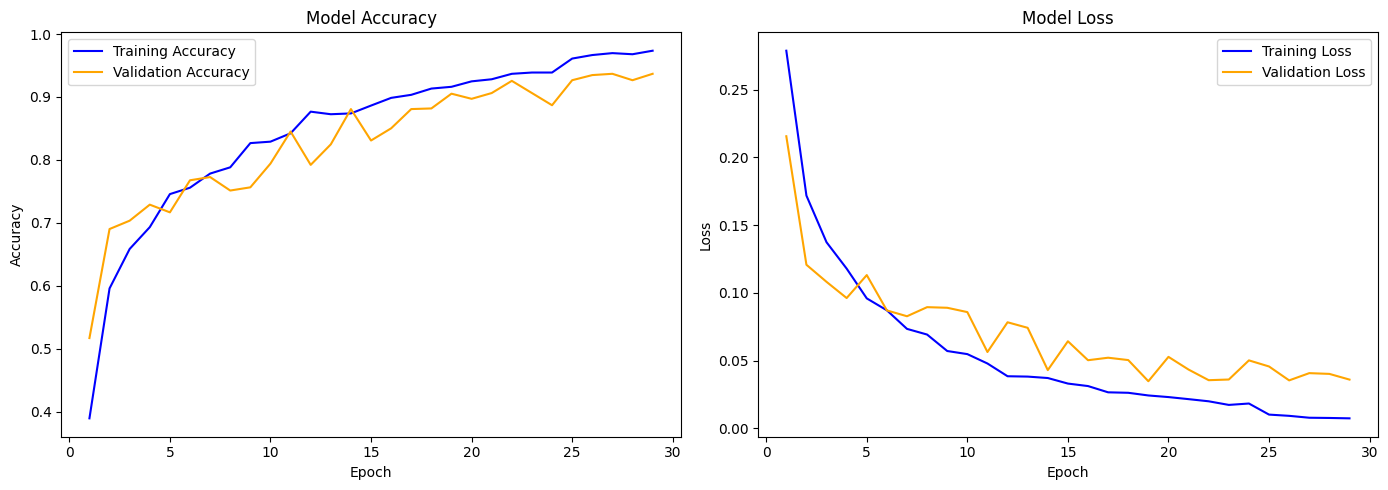

In [25]:
plot_training_history(history)


In [ ]:
# # Cell 12
# # Confusion Matrix and Classification Report

# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_test, axis=1)

# print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=le.classes_))

# cm = confusion_matrix(y_true, y_pred_classes)
# plt.figure(figsize=(8,6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
# plt.title('Confusion Matrix')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.show()


## Save model

In [ ]:
# # Cell 13
# # Save Model and Scaler

# model.save('emotion_model.h5')
# import pickle
# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)
# with open('label_encoder.pkl', 'wb') as f:
#     pickle.dump(le, f)


## Streamlit

In [ ]:
# # Cell 14
# # Test Function (For Streamlit Web App and Testing Script)

# def predict_emotion(file_path):
#     y, sr = librosa.load(file_path, duration=3, offset=0.5)
#     mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
#     mfcc_scaled = np.mean(mfcc.T, axis=0)
#     mfcc_scaled = scaler.transform([mfcc_scaled])
#     mfcc_scaled = mfcc_scaled[..., np.newaxis]
#     prediction = model.predict(mfcc_scaled)
#     predicted_emotion = le.inverse_transform([np.argmax(prediction)])
#     return predicted_emotion[0]
# # Example usage